In [4]:
# Load from pkl files
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import time
import tensorflow as tf
import os
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



mic_dframe = pd.read_csv('./Input/dados_teste/MIC_modelo.csv')
#mic_dframe.to_excel('./Output/mic_modelo.xlsx')

suscep_classes = pd.read_excel('./Input/dados_teste/suscep_classes_new_alt.xlsx')
    
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

antibiotics = mic_dframe.columns[-18:]
antibiotics = antibiotics.to_list()
antibiotics.pop(2)
antibiotics.pop(4)
antibiotics.pop(5)
antibiotics.pop(9)
antibiotics.pop(12)

#print(antibiotics)

def csv_to_nparray(path):
    values = []
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            values.append([int(i) for i in row])
        f.close()
    
    return np.asarray(values[0])

def txt_to_nparray(path):
    values = []
    with open(path, "r") as f:
        for line in f:
            values.append(line)
        f.close()
    
    return np.asarray(values)

def prob_to_onehot(y):
    for i in range(0, y.shape[0]):
        greater = 0
        pos = 0
        for j in range(0, y.shape[1]):
            if y[i][j] >= greater:
                greater = y[i][j]
                pos = j
            y[i][j] = 0.0
        y[i][pos] = 1.0
    return y

def best_N_features(target_df, antibiotic, N):
    genome_ids = target_df['Gene_ID'].loc[pd.notnull(target_df[antibiotic])].values
    folder_path = './Input/dados_teste/k10_counts/'
    final_list = []
    for txt_path in genome_ids:
        txt_path = txt_path + '.txt'
        temp_path = os.path.join(folder_path, txt_path)
        result = txt_to_nparray(temp_path)
        final_list.append(result)
    X = np.asarray(final_list)
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./Input/8-mers/kmers_basis.npy')
    selected_kmers = []
    n_best_selected = n_best.get_support()
    for i in range(0, len(n_best_selected)):
        if n_best_selected[i]:
            selected_kmers.append(kmers[i])
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    
    return best_feature_df


def class_weighting(df, antibiotic, cv):
    # Unique mic values
    mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].unique()
    # Samples per class
    samples = {mic : len(df.loc[df[antibiotic]==mic]) for mic in mics}
    # Sorted classes
    mics = sorted([key for key in samples.keys()])
    # total data
    total = len(df.loc[pd.notnull(df[antibiotic])])
    # class weights
    class_weight = {i: (1 / samples[mic])*(total/len(mics))*(1/cv) for i, mic in enumerate(mics)}
    
    return class_weight

def genomes_per_class(df, antibiotics):
    amounts = pd.DataFrame(data={})
    for antibiotic in antibiotics:
        single_amr = df[['Gene_ID',antibiotic]].loc[pd.notnull(df[antibiotic])].drop_duplicates()
        if single_amr.shape[0] == 0:
            mics = [4]
            amount = [0]
        else:
            # Unique mic values
            mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].sort_values().unique()
            amount = [len(single_amr.loc[single_amr[antibiotic]==mic]) for mic in mics]
        # Fiz uma alteracao para funcionar no pandas mais recente.
        amounts = pd.concat([amounts, pd.DataFrame(amount, index=mics).T], sort=True, ignore_index=True)
        #---------------------------------------------------------------
    return amounts

#models = {}
#callbacks = {}
#N_epochs = {}

In [3]:
#antibiotic = antibiotics[0]

antibiotic = antibiotics[0]

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotics[0], N=2000)

X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

KeyboardInterrupt: 

In [17]:


# Model building function
def make_model(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=500,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

model = make_model()


/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 205.16 seconds
Best Validation Loss: 1.53
Best Validation Accuracy: 0.52
Best Train Loss: 0.05
Best Train Accuracy: 0.98


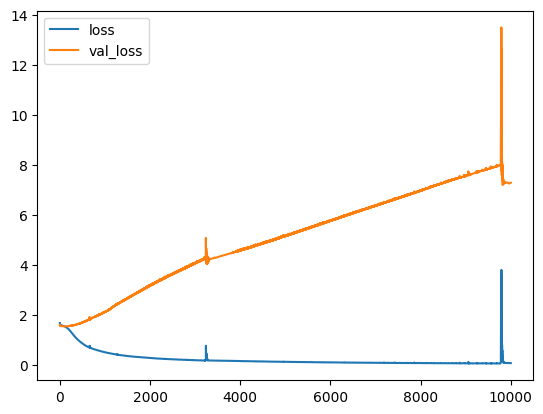

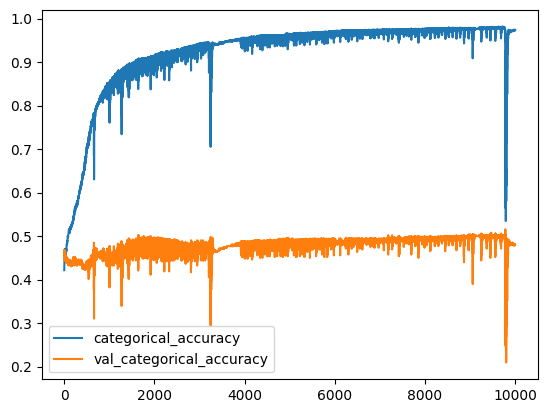

In [18]:
from sklearn.model_selection import train_test_split



# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)

import time

starttime = time.time()

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=4096,
    epochs=10000,
    #callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

# Plot the loss (accuracy) and validation loss (accuracy) functions

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
Validation accuracy: 0.5078534031413613


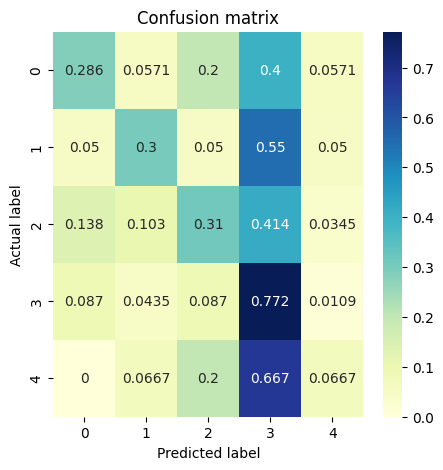

In [20]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
y_pred = prob_to_onehot(y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Validation accuracy: " + str(accuracy))


**Resultado Final**

Agora, para testar todos os modelos e comparar com a versão anterior de um modelo para todos.

In [12]:
def kfold_cv_split(X, y, n_splits, kfold):

    total_data = len(X)
    fold_size = total_data // n_splits
    X_folds = []
    y_folds = []
    for i in range(n_splits):
        start  = i * fold_size
        if i < n_splits-1:
            end = start + fold_size
        else:
            end = total_data
        X_folds.append(X[start:end,:])
        y_folds.append(y[start:end])
    
    if kfold == 0:
        train   = kfold + n_splits-2
        val         = kfold + n_splits-2
        test        = kfold + n_splits-1
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 1:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2)
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
        
    elif kfold == 2:
        train   = kfold + (n_splits-2)
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate(X_folds[kfold:train]), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate(y_folds[kfold:train]), y_folds[val], y_folds[test]
    
    else:
        train   = kfold + (n_splits-2) - n_splits
        val         = kfold + (n_splits-2) - n_splits
        test        = kfold + (n_splits-1) - n_splits
        X_train, X_val, X_test = np.concatenate((np.concatenate(X_folds[kfold:]),np.concatenate(X_folds[:train]))), X_folds[val], X_folds[test]
        y_train, y_val, y_test = np.concatenate((np.concatenate(y_folds[kfold:]),np.concatenate(y_folds[:train]))), y_folds[val], y_folds[test]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def kfold_cross_val(X, y, cv, labels):
    n_splits=cv
    kfold_accuracy = []
    for kfold in range(n_splits):
        # Split into the training, validation and test data
        X_train, X_val, X_test, y_train, y_val, y_test = kfold_cv_split(X, y, n_splits, kfold)
        # Define the model
        model = make_model()
        # Training
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=512,
            epochs=5000,
            callbacks=[early_stopping],
            class_weight = class_weights,
            verbose=0,
        )
        # Make predictions, compute the confusion matrix and extract the (per-class) accuracy
        y_pred = model.predict(X_test)
        mic_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]
        mic_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
        print(mic_pred)
        print(mic_test)
        cm = confusion_matrix(mic_test, mic_pred,labels=labels, normalize='true')
        print(cm)
        accuracy = 100*np.diagonal(cm)
        print(accuracy)
        # Save the accuracy per fold
        kfold_accuracy.append(accuracy)
    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy= [a.mean() for a in np.transpose(kfold_accuracy)]
    std_dev = [np.std(b) for b in np.transpose(kfold_accuracy)]
    var = [np.var(c) for c in np.transpose(kfold_accuracy)]
    return average_accuracy, std_dev, var, y_pred, y_test

In [13]:
# Cross validation number
CV = 5

average_accuracies = pd.DataFrame(data={})
std_devs = pd.DataFrame(data={})
var_df = pd.DataFrame(data={})
y_pred_df = pd.DataFrame(data={})
y_test_df = pd.DataFrame(data={})

for antibiotic in antibiotics:
    
    start_time = time.time()
    
    # Features
    kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic=antibiotic, N=200)
    X = kmer_dframe.values
    
    # Standardize the training data
    scaler_X = StandardScaler().fit(X)
    X_scaled = scaler_X.transform(X)
    
    # Target
    y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values
    y_reshape = np.reshape(y,(-1,1))
    encoder = OneHotEncoder(sparse_output=False)
    y_onehot = encoder.fit_transform(y_reshape)
    
    mics = sorted(np.unique(y), reverse=True)
    #print(mics)
    
    # Class weighting
    class_weights = class_weighting(mic_dframe, antibiotic, cv=CV)
    
    # Start modeling
    start_modeling_time = time.time()
    
    # Get the average (per-class) accuracy from k-fold cross-validation
    average_accuracy, std_dev, var, y_pred, y_test = kfold_cross_val(X_scaled, y_onehot, cv=CV, labels=mics)
    y_pred = prob_to_onehot(y=y_pred)
    #print(y_pred)
    #print(y_test)
    
    # Save dataframes with the average accuracy per mic value
    
    
    #average_accuracies.append(pd.DataFrame(average_accuracy, index=mics).T)
    average_accuracies = pd.concat([average_accuracies, pd.DataFrame(average_accuracy, index=mics).T], sort=True, ignore_index=True)
    std_devs = pd.concat([std_devs, pd.DataFrame(std_dev, index=mics).T], sort=True, ignore_index=True)
    var_df = pd.concat([var_df, pd.DataFrame(var, index=mics).T], sort=True, ignore_index=True)
    y_pred_df = pd.concat([y_pred_df, pd.DataFrame(y_pred)], ignore_index=False)
    y_test_df = pd.concat([y_test_df, pd.DataFrame(y_pred)], ignore_index=False)
    
    #Timing 
    final_modeling_time = time.time()
    final_time = time.time()
    
    print('Time: {:0.2f} s, Modeling Time: {:0.2f} s'.format(final_time - start_time, final_modeling_time - start_modeling_time))
    
# Overall average accuracy
overall_accuracy = average_accuracies

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
['16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '2.0', '8.0', '16.0', '16.0', '16.0', '16.0', '16.0', '16.0', '2.0', '16.0', '2.0', '2.0', '16.0', '2.0', '2.0', '8.0', '16.0', '16.0', '2.0', '2.0', '2.0', '16.0', '16.0', '16.0', '16.0', '2.0', '8.0', '16.0', '16.0', '16.0', '2.0', '16.0', '16.0', '2.0', '2.0', '16.0', '2.0', '2.0', '2.0', '8.0', '2.0', '16.0', '8.0', '16.0', '8.0', '16.0', '2.0', '2.0', '2.0', '8.0', '2.0', '2.0', '8.0', '2.0', '16.0', '16.0', '16.0', '2.0', '8.0', '2.0', '2.0', '16.0', '2.0', '16.0', '16.0', '2.0', '16.0', '16.0', '16.

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Unknown variable: <KerasVariable shape=(200, 64), dtype=float32, path=sequential_5/dense_20/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
print(y_pred_df)
print(y_test_df)

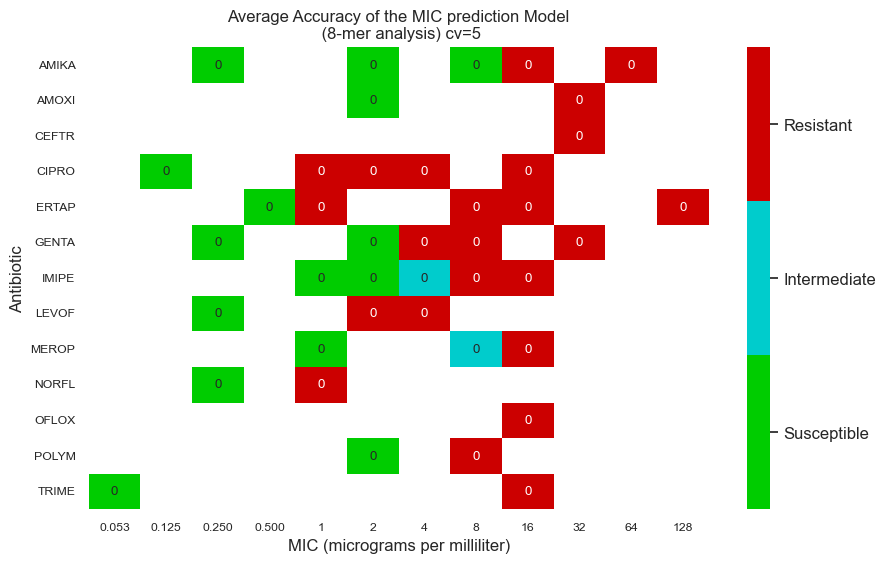

In [82]:
# Plot the overall average accuracy

from matplotlib.colors import LinearSegmentedColormap

def susceptibility_heatmap(data, annot, antibiotics, title):
    sns.set_theme(font_scale=.8, style='white')
    myColors = ((0.0, 0.8, 0.0, 1.0), (0.0, 0.8, 0.8, 1.0), (0.8, 0.0, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    # Abbreviate the antibiotic names to 5 letters
    antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
    # Number of genomes by Antibiotic and MIC.
    data = data.rename(index=antibiotic_abbre)
    # Set the width and height of the figure
    plt.figure(figsize=(10,6))
    # Add title
    plt.title(title, fontsize=12)
    # Heatmap showing the amount of genomes with the same MIC for each MIC, by antibiotic
    hp = sns.heatmap(data=data, annot=annot, cmap=cmap, fmt='.4g')
    # Manually specify colorbar labelling after it's been generated
    colorbar = hp.collections[0].colorbar
    colorbar.set_ticks([0.333, 1, 1.667])
    colorbar.set_ticklabels(['Susceptible', 'Intermediate', 'Resistant'])
    colorbar.ax.tick_params(labelsize=12)
    # Add label for horizontal axes
    plt.xlabel('MIC (micrograms per milliliter)', fontsize=12)
    plt.ylabel('Antibiotic', fontsize=12)

title = 'Average Accuracy of the MIC prediction Model\n (8-mer analysis) cv=' + str(CV)
#print(np.asarray(suscep_classes).shape)
#print(np.asarray(overall_accuracy).shape)
#print(antibiotics)
#print(suscep_classes)
#print(overall_accuracy)
susceptibility_heatmap(data=suscep_classes, annot=overall_accuracy, antibiotics=antibiotics, title=title)

**Calculando o Desvio Padrao e a Variancia**

<Axes: title={'center': 'Standard Deviation of the MIC prediction Model\n (8-mer analysis) cv=5'}>

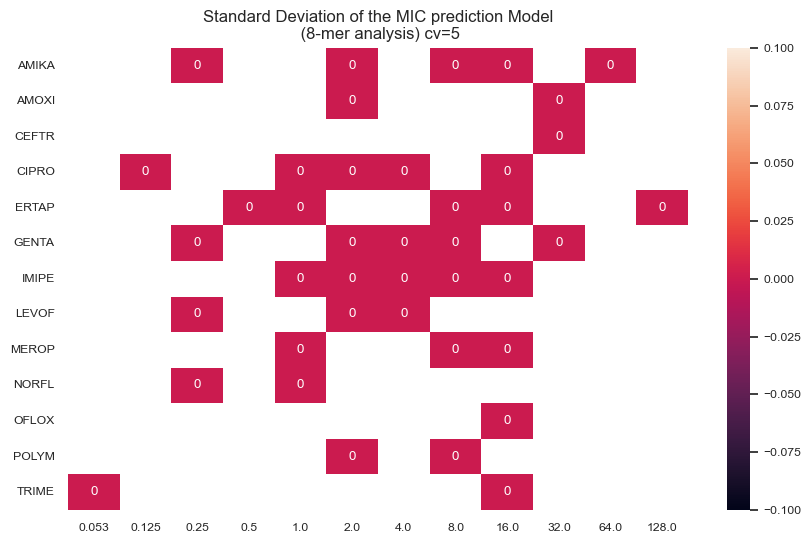

In [76]:
title = 'Standard Deviation of the MIC prediction Model\n (8-mer analysis) cv=' + str(CV)
antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
# Number of genomes by Antibiotic and MIC.
std_devs = std_devs.rename(index=antibiotic_abbre)
plt.figure(figsize=(10,6))
plt.title(title, fontsize=12)
sns.heatmap(data=std_devs, annot=True, robust=True, fmt='.4g')

<Axes: title={'center': 'Number of Genomes per Antibiotic and MIC'}>

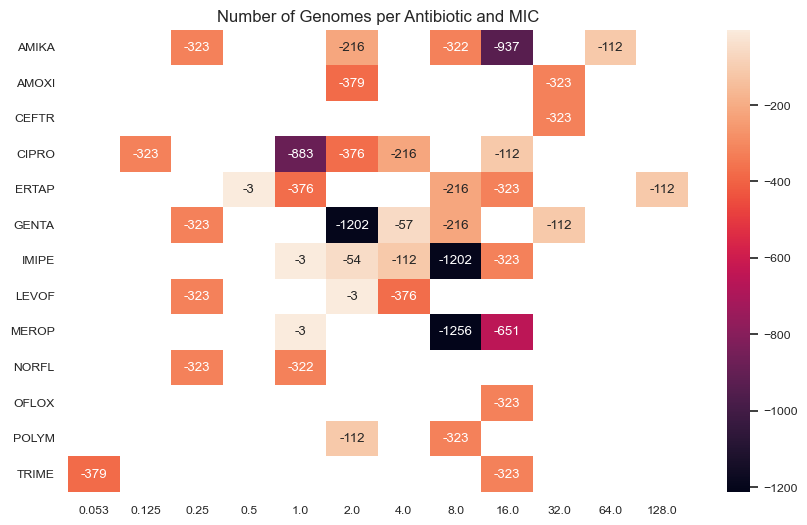

In [79]:
# Comupute the distribution of MIC measurements
mic_distribution = -1*genomes_per_class(mic_dframe, antibiotics)

# Combine the MIC distribution and the susceptibility map
title = 'Number of Genomes per Antibiotic and MIC'
# Abbreviate the antibiotic names to 5 letters
antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
# Number of genomes by Antibiotic and MIC.
mic_distribution = mic_distribution.rename(index=antibiotic_abbre)
plt.figure(figsize=(10,6))
plt.title(title, fontsize=12)
sns.heatmap(data=mic_distribution, annot=True, robust=True, fmt='.4g')

<Axes: title={'center': 'Variance of the MIC prediction Model\n (8-mer analysis) cv=5'}>

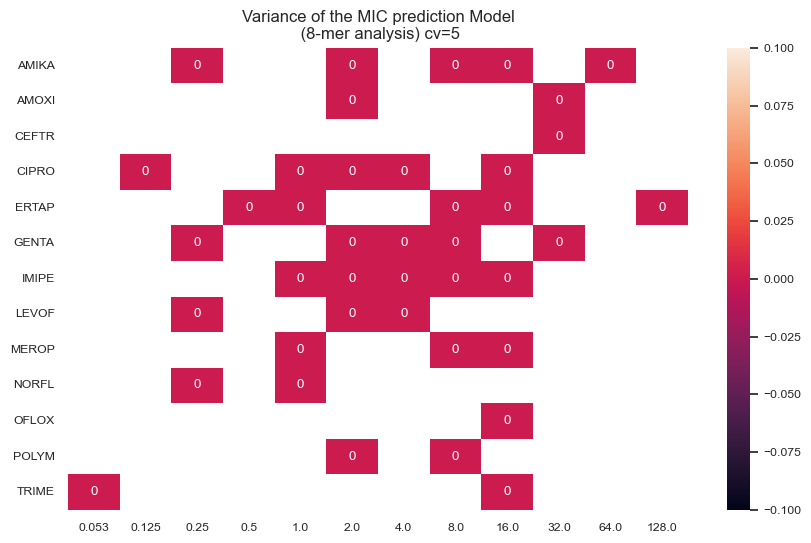

In [80]:
title = 'Variance of the MIC prediction Model\n (8-mer analysis) cv=' + str(CV)
antibiotic_abbre = {i:antibiotics[i][:5].upper() for i in range(len(antibiotics))}
# Number of genomes by Antibiotic and MIC.
var_df = var_df.rename(index=antibiotic_abbre)
plt.figure(figsize=(10,6))
plt.title(title, fontsize=12)
sns.heatmap(data=var_df, annot=True, robust=True, fmt='.4g')